In [4]:
import numpy as np
import torch

def augment_xrd(
    batch_q,
    batch_iq,
    qmin=0.0,
    qmax=10.0,
    qstep=0.01,
    fwhm_range=(0.001, 0.5),
    noise_range=(0.001, 0.025),
    intensity_scale_range=(0.95, 1.0),
    mask_prob=0.1,
    eta_range=(0.5, 0.5)  # Mixing range for pseudo-Voigt, 1.0 is fully Lorentzian
):
    # Define the continuous Q grid
    q_cont = np.arange(qmin, qmax, qstep)
    augmented_patterns = []

    for q, iq in zip(batch_q, batch_iq):
        # Initialize intensities_continuous
        iq_cont = np.zeros_like(q_cont)
        
        # Sample a random FWHM and eta value for the pseudo-Voigt function
        fwhm = np.random.uniform(*fwhm_range)
        eta = np.random.uniform(*eta_range)  # Control Gaussian-Lorentzian mix
        
        # Convert FWHM to standard deviations for Gaussian and Lorentzian parts
        sigma_gauss = fwhm / (2 * np.sqrt(2 * np.log(2)))
        gamma_lorentz = fwhm / 2

        # Apply pseudo-Voigt broadening to the peaks
        for q_peak, iq_peak in zip(q, iq):
            if q_peak != 0:
                # Gaussian component
                gaussian_component = np.exp(-0.5 * ((q_cont - q_peak) / sigma_gauss) ** 2)
                # Lorentzian component
                lorentzian_component = 1 / (1 + ((q_cont - q_peak) / gamma_lorentz) ** 2)
                # Combine to form pseudo-Voigt
                pseudo_voigt = eta * lorentzian_component + (1 - eta) * gaussian_component
                iq_cont += iq_peak * pseudo_voigt

        # Normalize the continuous intensities
        iq_cont /= (np.max(iq_cont) + 1e-16)
        
        # Random scaling of intensities
        if intensity_scale_range is not None:
            intensity_scale = np.random.uniform(*intensity_scale_range)
            iq_cont = iq_cont * intensity_scale
        
        # Random noise addition
        if noise_range is not None:
            noise_scale = np.random.uniform(*noise_range)
            background = np.random.randn(len(iq_cont)) * noise_scale
            iq_cont = iq_cont + background
        
        # Random masking
        if mask_prob is not None:
            mask = np.random.rand(len(iq_cont)) > mask_prob
            iq_cont = iq_cont * mask
        
        # Clipping
        iq_cont = np.clip(iq_cont, a_min=0.0, a_max=None)
        
        # Append to list
        augmented_patterns.append(iq_cont.astype(np.float32))
        
    # Stack all augmented patterns into a numpy array
    xrd_augmented_batch = np.stack(augmented_patterns)
    
    # Convert to torch tensor
    xrd_augmented_batch = torch.from_numpy(xrd_augmented_batch)
    
    return xrd_augmented_batch

    
# Original Gaussian-based function
def augment_xrd_gaussian(
    batch_q,
    batch_iq,
    qmin=0.0,
    qmax=10.0,
    qstep=0.01,
    fwhm_range=(0.001, 0.5),
    noise_range=(0.001, 0.025),
    intensity_scale_range=None,
    mask_prob=None,
):
    # Define the continuous Q grid
    q_cont = np.arange(qmin, qmax, qstep)
    augmented_patterns = []
        
    for q, iq in zip(batch_q, batch_iq):
        # Initialize intensities_continuous
        iq_cont = np.zeros_like(q_cont)
        
        # Sample a random FWHM from fwhm_range and convert to standard deviation
        fwhm = np.random.uniform(*fwhm_range)
        sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
        
        # Apply Gaussian broadening to the peaks
        for q_peak, iq_peak in zip(q, iq):
            if q_peak != 0:
                gaussian_broadening = iq_peak * np.exp(-0.5 * ((q_cont - q_peak) / sigma) ** 2)
                iq_cont += gaussian_broadening
        
        # Normalize the continuous intensities
        iq_cont /= (np.max(iq_cont) + 1e-16)
        
        # Random scaling of intensities
        if intensity_scale_range is not None:
            intensity_scale = np.random.uniform(*intensity_scale_range)
            iq_cont = iq_cont * intensity_scale
        
        # Random noise addition
        if noise_range is not None:
            noise_scale = np.random.uniform(*noise_range)
            background = np.random.randn(len(iq_cont)) * noise_scale
            iq_cont = iq_cont + background
        
        # Random masking
        if mask_prob is not None:
            mask = np.random.rand(len(iq_cont)) > mask_prob
            iq_cont = iq_cont * mask
        
        # Clipping
        iq_cont = np.clip(iq_cont, a_min=0.0, a_max=None)
        
        # Append to list
        augmented_patterns.append(iq_cont.astype(np.float32))
        
    # Stack all augmented patterns into a numpy array
    xrd_augmented_batch = np.stack(augmented_patterns)
    
    # Convert to torch tensor
    xrd_augmented_batch = torch.from_numpy(xrd_augmented_batch)
    
    return xrd_augmented_batch

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Simulate batch data
batch_q = [np.array([1.0, 2.0, 3.0, 4.0]), np.array([0.5, 1.5, 2.5, 3.5])]
batch_iq = [np.array([10, 20, 15, 30]), np.array([5, 15, 10, 25])]

# Define fwhm and noise values to sweep
fwhm_values = [0.01, 0.1, 0.3, 0.5]
noise_values = [0.001, 0.01, 0.02, 0.05]

# Store results to plot
results_gaussian = {}
results_pseudo_voigt = {}

# Generate augmented patterns for each combination of fwhm and noise
for fwhm in fwhm_values:
    for noise in noise_values:
        # Gaussian-based
        augmented_gaussian = augment_xrd_gaussian(
            batch_q, 
            batch_iq, 
            fwhm_range=(fwhm, fwhm),  
            noise_range=(noise, noise),  
            intensity_scale_range=None,
            mask_prob=None
        )
        results_gaussian[(fwhm, noise)] = augmented_gaussian[0].numpy()
        
        # Pseudo-Voigt-based
        augmented_pseudo_voigt = augment_xrd(
            batch_q, 
            batch_iq, 
            fwhm_range=(fwhm, fwhm),  
            noise_range=(noise, noise),  
            intensity_scale_range=None,
            mask_prob=None,
            eta_range=None  # Assuming a fixed eta range for pseudo-Voigt
        )
        results_pseudo_voigt[(fwhm, noise)] = augmented_pseudo_voigt[0].numpy()

# Plotting
q_cont = np.arange(0.0, 10.0, 0.01)
plt.figure(figsize=(15, 12))

for i, ((fwhm, noise), iq_cont_gaussian) in enumerate(results_gaussian.items(), start=1):
    iq_cont_pseudo_voigt = results_pseudo_voigt[(fwhm, noise)]
    
    plt.subplot(len(fwhm_values), len(noise_values), i)
    plt.plot(q_cont, iq_cont_gaussian, 'b-', label="Gaussian", linewidth=1.5)
    plt.plot(q_cont, iq_cont_pseudo_voigt, 'r--', label="Pseudo-Voigt", linewidth=1.5)
    plt.title(f"FWHM: {fwhm}, Noise: {noise}")
    plt.xlabel("Q")
    plt.ylabel("Intensity")
    plt.ylim(0, 1)  # Consistent scale for comparison
    plt.legend()

plt.tight_layout()
plt.show()


TypeError: RandomState.uniform() argument after * must be an iterable, not NoneType

In [11]:
import torch
import numpy as np

# Original disc_to_cont_xrd function (with the inner loop)
def disc_to_cont_xrd_original(
    batch_q,
    batch_iq,
    qmin=0.0,
    qmax=10.0,
    qstep=0.01,
    fwhm_range=(0.001, 0.5),
    noise_range=(0.001, 0.025),
    intensity_scale_range=None,
    mask_prob=None,
    eta_range=(0.5, 1.0)
):
    q_cont = torch.arange(qmin, qmax, qstep)
    augmented_patterns = []
    
    for q, iq in zip(batch_q, batch_iq):
        q = torch.as_tensor(q, dtype=torch.float32)
        iq = torch.as_tensor(iq, dtype=torch.float32)
        iq_cont = torch.zeros_like(q_cont)
        
        fwhm = torch.empty(1).uniform_(*fwhm_range).item()
        eta = torch.empty(1).uniform_(*eta_range).item()
        
        sigma_gauss = fwhm / (2 * torch.sqrt(2 * torch.log(torch.tensor(2.0))))
        gamma_lorentz = fwhm / 2
        
        for q_peak, iq_peak in zip(q, iq):
            if q_peak != 0:
                delta_q = q_cont - q_peak
                gaussian_component = torch.exp(-0.5 * (delta_q / sigma_gauss) ** 2)
                lorentzian_component = 1 / (1 + (delta_q / gamma_lorentz) ** 2)
                pseudo_voigt = eta * lorentzian_component + (1 - eta) * gaussian_component
                iq_cont += iq_peak * pseudo_voigt
        
        iq_cont /= (iq_cont.max() + 1e-16)
        
        if intensity_scale_range is not None:
            intensity_scale = torch.empty(1).uniform_(*intensity_scale_range).item()
            iq_cont *= intensity_scale
        
        if noise_range is not None:
            noise_scale = torch.empty(1).uniform_(*noise_range).item()
            iq_cont += torch.randn(len(iq_cont)) * noise_scale
        
        if mask_prob is not None:
            mask = (torch.rand(len(iq_cont)) > mask_prob).float()
            iq_cont *= mask
        
        iq_cont = torch.clamp(iq_cont, min=0.0)
        augmented_patterns.append(iq_cont)
    
    xrd_augmented_batch = torch.stack(augmented_patterns)
    return xrd_augmented_batch

# Optimized disc_to_cont_xrd function
def disc_to_cont_xrd_optimized(
    batch_q,
    batch_iq,
    qmin=0.0,
    qmax=10.0,
    qstep=0.01,
    fwhm_range=(0.001, 0.5),
    noise_range=(0.001, 0.025),
    intensity_scale_range=None,
    mask_prob=None,
    eta_range=(0.5, 1.0)
):
    q_cont = torch.arange(qmin, qmax, qstep)
    augmented_patterns = []
    
    for q, iq in zip(batch_q, batch_iq):
        q = torch.as_tensor(q, dtype=torch.float32)
        iq = torch.as_tensor(iq, dtype=torch.float32)
        
        fwhm = torch.empty(1).uniform_(*fwhm_range).item()
        eta = torch.empty(1).uniform_(*eta_range).item()
        
        sigma_gauss = fwhm / (2 * torch.sqrt(2 * torch.log(torch.tensor(2.0))))
        gamma_lorentz = fwhm / 2
        
        delta_q = q_cont[:, None] - q[None, :]
        gaussian_component = torch.exp(-0.5 * (delta_q / sigma_gauss) ** 2)
        lorentzian_component = 1 / (1 + (delta_q / gamma_lorentz) ** 2)
        pseudo_voigt = eta * lorentzian_component + (1 - eta) * gaussian_component
        iq_cont = (pseudo_voigt * iq[None, :]).sum(dim=1)
        
        iq_cont /= (iq_cont.max() + 1e-16)
        
        if intensity_scale_range is not None:
            intensity_scale = torch.empty(1).uniform_(*intensity_scale_range).item()
            iq_cont *= intensity_scale
        
        if noise_range is not None:
            noise_scale = torch.empty(1).uniform_(*noise_range).item()
            iq_cont += torch.randn(len(iq_cont)) * noise_scale
        
        if mask_prob is not None:
            mask = (torch.rand(len(iq_cont)) > mask_prob).float()
            iq_cont *= mask
        
        iq_cont = torch.clamp(iq_cont, min=0.0)
        augmented_patterns.append(iq_cont)
    
    xrd_augmented_batch = torch.stack(augmented_patterns)
    return xrd_augmented_batch

# Simulate batch data
batch_q = [np.array([1.0, 2.0, 3.0]), np.array([0.5, 1.5, 2.5])]
batch_iq = [np.array([10, 20, 15]), np.array([5, 15, 10])]

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Run original function
output_original = disc_to_cont_xrd_original(
    batch_q,
    batch_iq,
    intensity_scale_range=None,
    mask_prob=None,
    noise_range=(0.0, 0.0),  # Set noise to zero for comparison
    fwhm_range=(0.1, 0.1),   # Fixed FWHM for comparison
    eta_range=(0.7, 0.7)     # Fixed eta for comparison
)

# Reset random seed
torch.manual_seed(0)
np.random.seed(0)

# Run optimized function
output_optimized = disc_to_cont_xrd_optimized(
    batch_q,
    batch_iq,
    intensity_scale_range=None,
    mask_prob=None,
    noise_range=(0.0, 0.0),  # Set noise to zero for comparison
    fwhm_range=(0.1, 0.1),   # Fixed FWHM for comparison
    eta_range=(0.7, 0.7)     # Fixed eta for comparison
)

# Verify if the outputs are close
are_close = torch.allclose(output_original, output_optimized, atol=1e-6)
print(f"Outputs are the same: {are_close}")


Outputs are the same: True


In [10]:
import time

# Simulate batch data with larger size and more peaks
batch_size = 100
num_peaks = 50
batch_q = [torch.linspace(1.0, 5.0, num_peaks) for _ in range(batch_size)]
batch_iq = [torch.rand(num_peaks) * 100 for _ in range(batch_size)]

# Measure time for the original function (assuming it's defined)
start_time = time.time()
xrd_augmented_original = disc_to_cont_xrd(
    batch_q, batch_iq, intensity_scale_range=None, mask_prob=None
)
original_time = time.time() - start_time

# Measure time for the optimized function
start_time = time.time()
xrd_augmented_optimized = disc_to_cont_xrd_opt(
    batch_q, batch_iq, intensity_scale_range=None, mask_prob=None
)
optimized_time = time.time() - start_time

print(f"Original function time: {original_time:.4f} seconds")
print(f"Optimized function time: {optimized_time:.4f} seconds")


Original function time: 0.3084 seconds
Optimized function time: 0.0417 seconds


In [27]:
import torch

def disc_to_cont_xrd_original(
    batch_q,
    batch_iq,
    q_cont,
    fwhm_range=(0.001, 0.5),
    noise_range=(0.001, 0.025),
    intensity_scale_range=(0.95, 1.05),
    mask_prob=None,
    eta_range=(0.5, 1.0)
):
    batch_size, max_num_peaks = batch_q.shape
    num_q_points = q_cont.shape[0]
    augmented_patterns = []

    for i in range(batch_size):
        q = batch_q[i]          # Shape: (max_num_peaks,)
        iq = batch_iq[i]        # Shape: (max_num_peaks,)

        # Filter out padded values (assumes padded values are 0)
        valid_peaks = q != 0
        q = q[valid_peaks]
        iq = iq[valid_peaks]

        # Initialize continuous intensities
        iq_cont = torch.zeros(num_q_points)

        # Sample random FWHM, eta, noise, and intensity scale
        fwhm = torch.empty(1).uniform_(*fwhm_range).item()
        eta = torch.empty(1).uniform_(*eta_range).item()
        noise_scale = torch.empty(1).uniform_(*noise_range).item()
        intensity_scale = torch.empty(1).uniform_(*intensity_scale_range).item()

        # Convert FWHM to standard deviations
        sigma_gauss = fwhm / (2 * torch.sqrt(2 * torch.log(torch.tensor(2.0))))
        gamma_lorentz = fwhm / 2

        # Loop over peaks
        for q_peak, iq_peak in zip(q, iq):
            delta_q = q_cont - q_peak
            gaussian_component = torch.exp(-0.5 * (delta_q / sigma_gauss) ** 2)
            lorentzian_component = 1 / (1 + (delta_q / gamma_lorentz) ** 2)
            pseudo_voigt = eta * lorentzian_component + (1 - eta) * gaussian_component
            iq_cont += iq_peak * pseudo_voigt

        # Normalize and apply intensity scaling
        iq_cont /= (iq_cont.max() + 1e-16)
        iq_cont *= intensity_scale

        # Add random noise
        iq_cont += torch.randn(num_q_points) * noise_scale

        # Apply random masking
        if mask_prob is not None:
            mask = (torch.rand(num_q_points) > mask_prob).float()
            iq_cont *= mask

        # Append to list
        augmented_patterns.append(iq_cont)

    # Stack into a tensor
    xrd_augmented_batch = torch.stack(augmented_patterns)
    return xrd_augmented_batch  # Shape: (batch_size, num_q_points)


In [33]:
import torch

def disc_to_cont_xrd_vectorized(
    batch_q,
    batch_iq,
    q_cont,
    fwhm_range=(0.001, 0.5),
    noise_range=(0.001, 0.025),
    intensity_scale_range=(0.95, 1.05),
    mask_prob=None,
    eta_range=(0.5, 1.0)
):
    batch_size, max_num_peaks = batch_q.shape
    num_q_points = q_cont.shape[0]

    # Sample random FWHM, eta, noise, and intensity scale values for each sample
    fwhm = torch.empty(batch_size, 1, 1).uniform_(*fwhm_range)  # Shape: (batch_size, 1, 1)
    eta = torch.empty(batch_size, 1, 1).uniform_(*eta_range)    # Shape: (batch_size, 1, 1)
    noise_scale = torch.empty(batch_size, 1).uniform_(*noise_range)  # Shape: (batch_size, 1)
    intensity_scale = torch.empty(batch_size, 1).uniform_(*intensity_scale_range)  # Shape: (batch_size, 1)

    # Apply intensity scaling to peak intensities
    batch_iq = batch_iq * intensity_scale

    # Convert FWHM to standard deviations
    sigma_gauss = fwhm / (2 * torch.sqrt(2 * torch.log(torch.tensor(2.0))))
    gamma_lorentz = fwhm / 2

    # Expand dimensions for broadcasting
    q_cont_expanded = q_cont.view(1, num_q_points, 1)            # Shape: (1, num_q_points, 1)
    batch_q_expanded = batch_q.unsqueeze(1)                      # Shape: (batch_size, 1, max_num_peaks)
    delta_q = q_cont_expanded - batch_q_expanded                 # Shape: (batch_size, num_q_points, max_num_peaks)

    # Compute Gaussian and Lorentzian components
    gaussian_component = torch.exp(-0.5 * (delta_q / sigma_gauss) ** 2)
    lorentzian_component = 1 / (1 + (delta_q / gamma_lorentz) ** 2)
    pseudo_voigt = eta * lorentzian_component + (1 - eta) * gaussian_component

    # Apply peak intensities and filter out padded values
    batch_iq_expanded = batch_iq.unsqueeze(1)                    # Shape: (batch_size, 1, max_num_peaks)
    valid_peaks = (batch_q_expanded != 0).float()                # Shape: (batch_size, 1, max_num_peaks)
    iq_cont = (pseudo_voigt * batch_iq_expanded * valid_peaks).sum(dim=2)  # Shape: (batch_size, num_q_points)

    # Normalize
    iq_cont /= (iq_cont.max(dim=1, keepdim=True)[0] + 1e-16)

    # Add random noise
    noise = torch.randn(batch_size, num_q_points) * noise_scale
    iq_cont += noise

    # Apply random masking
    if mask_prob is not None:
        mask = (torch.rand(batch_size, num_q_points) > mask_prob).float()
        iq_cont *= mask

    return iq_cont  # Shape: (batch_size, num_q_points)


In [34]:
import torch
import time

# Simulate batch data (already padded)
batch_size = 100
max_num_peaks = 50
num_q_points = 1000

# Continuous Q grid
q_cont = torch.linspace(0.0, 10.0, num_q_points)

# Simulated padded batch_q and batch_iq with masks
batch_q = torch.zeros(batch_size, max_num_peaks)
batch_iq = torch.zeros(batch_size, max_num_peaks)
peak_mask = torch.zeros(batch_size, max_num_peaks)

for i in range(batch_size):
    num_peaks = torch.randint(1, max_num_peaks + 1, (1,)).item()
    batch_q[i, :num_peaks] = torch.sort(torch.rand(num_peaks) * 10.0)[0]
    batch_iq[i, :num_peaks] = torch.rand(num_peaks) * 100
    peak_mask[i, :num_peaks] = 1  # Valid peaks

# Set random seed for reproducibility
torch.manual_seed(0)

# Run and time the original function
start_time = time.time()
output_original = disc_to_cont_xrd_original(
    batch_q,
    batch_iq,
    q_cont,
    fwhm_range=(0.1, 0.1),      # Fixed FWHM for comparison
    noise_range=(0.01, 0.1),     # No noise for comparison
    intensity_scale_range=(0.95, 1.0),
    mask_prob=0.1,
    eta_range=(0.7, 0.7),       # Fixed eta for comparison
)
original_time = time.time() - start_time

# Set random seed again for reproducibility
torch.manual_seed(0)

# Run and time the vectorized function
start_time = time.time()
output_vectorized = disc_to_cont_xrd_vectorized(
    batch_q,
    batch_iq,
    q_cont,
    fwhm_range=(0.1, 0.1),      # Fixed FWHM for comparison
    noise_range=(0.01, 0.1),     # No noise for comparison
    intensity_scale_range=(0.95, 1.0),
    mask_prob=0.1,
    eta_range=(0.7, 0.7),       # Fixed eta for comparison
)
vectorized_time = time.time() - start_time

# Verify outputs are close
are_close = torch.allclose(output_original, output_vectorized, atol=1e-6)
print(f"Outputs are the same: {are_close}")

print(f"Original function time: {original_time:.4f} seconds")
print(f"Vectorized function time: {vectorized_time:.4f} seconds")


Outputs are the same: False
Original function time: 0.1480 seconds
Vectorized function time: 0.0397 seconds


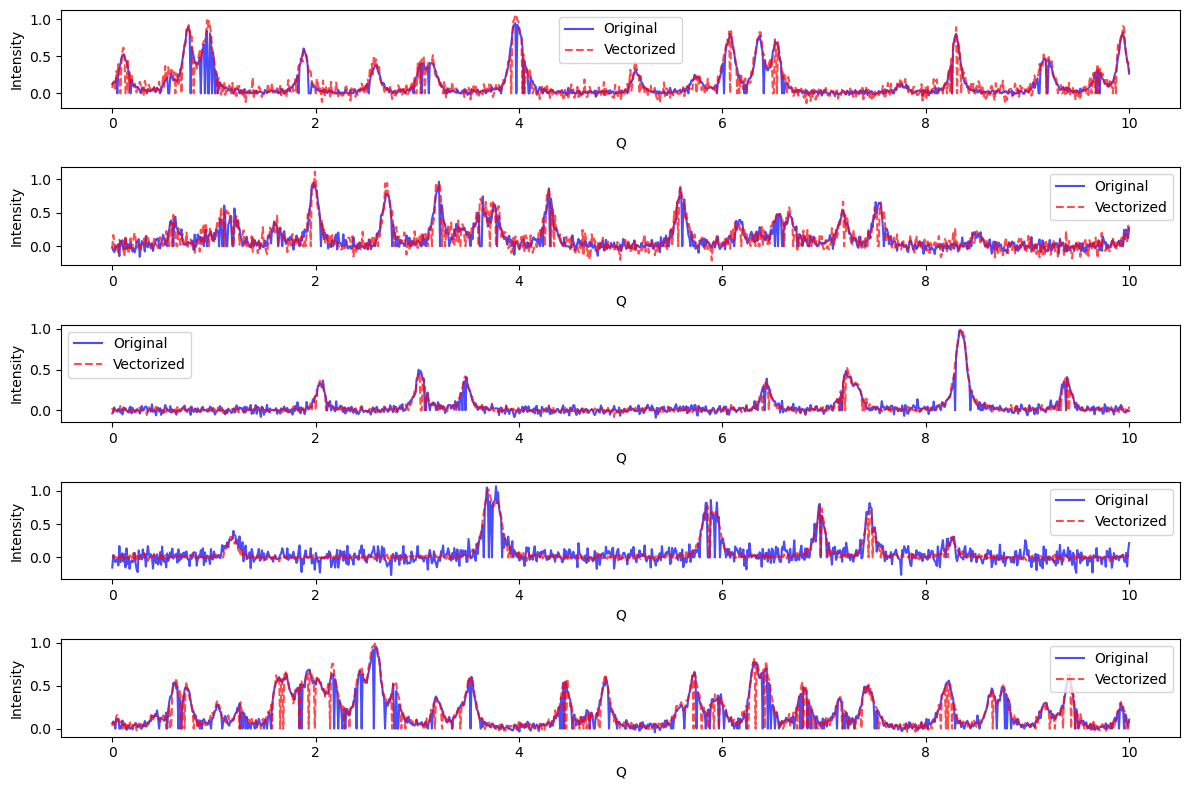

In [35]:
import matplotlib.pyplot as plt

# Plot a few samples from the output
num_samples_to_plot = 5
plt.figure(figsize=(12, 8))

for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(q_cont, output_original[i].cpu(), label="Original", linestyle='-', color='blue', alpha=0.7)
    plt.plot(q_cont, output_vectorized[i].cpu(), label="Vectorized", linestyle='--', color='red', alpha=0.7)
    plt.legend()
    plt.xlabel("Q")
    plt.ylabel("Intensity")

plt.tight_layout()
plt.show()
